In [1]:
import numpy as np
import pandas as pd

data=pd.read_csv("F:\Tutorials\Certified program in MACHINE LEARNING and ARTIFICIAL INTELLIGENCE\Assignments\project\dataset\data.csv",encoding='unicode_escape')
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [2]:
data=data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5836 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5836 non-null   object
 1   Sentiment  5836 non-null   object
dtypes: object(2)
memory usage: 136.8+ KB


In [3]:
#labeling target variable
dict_label= {'positive': 0, 'neutral': 0 , 'negative': 1}
data.Sentiment = data.Sentiment.map(dict_label)
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,0
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",1
2,"For the last quarter of 2010 , Componenta 's n...",0
3,According to the Finnish-Russian Chamber of Co...,0
4,The Swedish buyout firm has sold its remaining...,0


In [4]:
data.Sentiment.value_counts()

0    4976
1     860
Name: Sentiment, dtype: int64

In [5]:
4976//860

5

## Create the dataframe to be augmented 

In [6]:
dfX=data[data["Sentiment"]==1].reset_index(drop=True)
dfX.head()

,Sentence,Sentiment
0,"$ESI on lows, down $1.50 to $2.50 BK a real po...",1
1,Shell's $70 Billion BG Deal Meets Shareholder ...,1
2,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,1
3,$SAP Q1 disappoints as #software licenses down...,1
4,$AAPL afternoon selloff as usual will be bruta...,1


## Data Augmentation by Synonym Replacement 

In [7]:
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import random 

def get_synonyms(word):
    
    synonyms = set()
    
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

stop_words = []
for w in stopwords.words('english'):
    stop_words.append(w)
#print(stop_words)

def synonym_replacement(words, n):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

In [8]:

dfX_Aug=[]
for k in range(len(dfX)):
    trial_sent = dfX.Sentence[k]
    for n in range(6):
        txt= synonym_replacement(trial_sent,n)
        dfX_Aug.append(txt)

In [9]:
dfXAugmented=pd.DataFrame(dfX_Aug,columns=['Sentence'])
dfXAugmented['Sentiment'] = 1
dfXAugmented.head(10)

,Sentence,Sentiment
0,"$ESI on lows, down $1.50 to $2.50 bk a real po...",1
1,"$ESI on lows, down $1.50 to $2.50 berkelium a ...",1
2,"$ESI on lows, down $1.50 to $2.50 BK a very th...",1
3,"$ESI on lows, down $1.50 to $2.50 berkelium a ...",1
4,"$ESI on lows, down $1.50 to $2.50 bk a existen...",1
5,"$ESI on lows, down $1.50 to $2.50 bk a rattlin...",1
6,Shell's $70 Billion BG Deal Meets Shareholder ...,1
7,Shell's $70 Billion BG Deal contact Shareholde...,1
8,Shell's $70 Billion BG mess Meets Shareholder ...,1
9,Shell's $70 jillion BG Deal foregather Shareho...,1


In [10]:
df1=data[data["Sentiment"]==0].reset_index(drop=True)
df2=dfXAugmented
frames = [df1, df2]
  
X = pd.concat(frames)
display(X )

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,0
1,"For the last quarter of 2010 , Componenta 's n...",0
2,According to the Finnish-Russian Chamber of Co...,0
3,The Swedish buyout firm has sold its remaining...,0
4,$SPY wouldn't be surprised to see a green close,0
...,...,...
5155,RISING costs have forced packaging manufacture...,1
5156,RISING costs have forced packaging manufacture...,1
5157,RISING costs have forced packaging manufacture...,1
5158,RISING costs have constrained packaging produc...,1


In [11]:
X .Sentiment.value_counts()

1    5160
0    4976
Name: Sentiment, dtype: int64

In [12]:
X.to_csv('file_dataAug.csv')

## Split to train and test data 

In [13]:
from sklearn.model_selection import train_test_split
XTrain,XTest=train_test_split(X,test_size=0.2,random_state=42)

# Data Preprocessing

In [14]:
from keras.preprocessing import text
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 1000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize our training data
tokenizer=text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(list(XTrain.Sentence))
# Get our training data word index
word_index = tokenizer.word_index
# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(XTrain.Sentence)
# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])
# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)


print("\nPadded training shape:", train_padded.shape)



Padded training shape: (8108, 58)


In [15]:
test_sequences = tokenizer.texts_to_sequences(XTest.Sentence)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

print("\nPadded testing shape:",test_padded.shape)



Padded testing shape: (2028, 58)


In [16]:
for x, y in zip(XTest.Sentence, test_padded):
  print('{} -> {}'.format(x, y))

print("\nWord index (for reference):", word_index)

The EU Commission said earlier it had fined ThyssenKrupp , United technology Corp 's Otis , Schindler AG and Kone Oyj a total of 992.3 mln eur for alleged cartel action in the lift market going back twelve years . -> [  1  34 121  32 143 739 194 311  11   5 772  55   6 108   2  25  41   7
   8 809   3   1  72 388 218 478   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
Atria will also buy the shares of Kauhajoen Teurastamokiinteistot Oy (Kauhajoki slaughterhouse property)from Itikka Co-operative . -> [890  17  93 268   1  73   2 294   9  42   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
The turn of corporal combat injury casing quadruple in 2000-2006 . -> [  1 447   2   3  71   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0

### Create an RNN model 

In [16]:
X_train,y_train=train_padded,XTrain.Sentiment
X_test,y_test=test_padded,XTest.Sentiment

# train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2, random_state=42,
                                                  stratify=y_train)

In [17]:
from sklearn.model_selection import cross_val_score
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)

import warnings
warnings.filterwarnings("ignore", category=Warning) 
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option("display.max_columns", None)

In [18]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SimpleRNN,Dropout
score_acc = make_scorer(accuracy_score)


In [19]:
model=Sequential()
model.add(Embedding(input_dim=len(word_index)+1,output_dim=128))
model.add(SimpleRNN(50))
model.add(Dense(72, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adadelta(lr=0.106), metrics=['accuracy'])
model.summary()    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1597952   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 50)                8950      
_________________________________________________________________
dense (Dense)                (None, 72)                3672      
_________________________________________________________________
dropout (Dropout)            (None, 72)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 73        
Total params: 1,610,647
Trainable params: 1,610,647
Non-trainable params: 0
_________________________________________________________________


In [20]:
history=model.fit(X_train,y_train,batch_size=262,epochs=41,verbose=2,validation_data=(X_test,y_test ))

Epoch 1/41
25/25 - 3s - loss: 0.6966 - accuracy: 0.4961 - val_loss: 0.6939 - val_accuracy: 0.4936
Epoch 2/41
25/25 - 2s - loss: 0.6925 - accuracy: 0.5143 - val_loss: 0.6917 - val_accuracy: 0.5330
Epoch 3/41
25/25 - 3s - loss: 0.6897 - accuracy: 0.5281 - val_loss: 0.6890 - val_accuracy: 0.5459
Epoch 4/41
25/25 - 2s - loss: 0.6832 - accuracy: 0.5620 - val_loss: 0.6841 - val_accuracy: 0.5621
Epoch 5/41
25/25 - 2s - loss: 0.6744 - accuracy: 0.5833 - val_loss: 0.6774 - val_accuracy: 0.5740
Epoch 6/41
25/25 - 2s - loss: 0.6653 - accuracy: 0.6033 - val_loss: 0.6774 - val_accuracy: 0.5858
Epoch 7/41
25/25 - 2s - loss: 0.6499 - accuracy: 0.6317 - val_loss: 0.6533 - val_accuracy: 0.6252
Epoch 8/41
25/25 - 2s - loss: 0.6296 - accuracy: 0.6570 - val_loss: 0.6336 - val_accuracy: 0.6632
Epoch 9/41
25/25 - 2s - loss: 0.6112 - accuracy: 0.6785 - val_loss: 0.6336 - val_accuracy: 0.6484
Epoch 10/41
25/25 - 2s - loss: 0.5853 - accuracy: 0.7072 - val_loss: 0.5996 - val_accuracy: 0.6982
Epoch 11/41
25/25 -

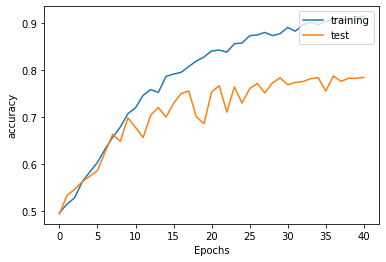

In [21]:
import matplotlib.pyplot as plt
metrics='accuracy'
plt.plot(history.history[metrics])
plt.plot(history.history['val_'+ metrics])
plt.xlabel('Epochs')
plt.ylabel(metrics)
plt.legend(['training', 'test'], loc='upper right')
plt.show()
     

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

def plot_conf(ypred,y_test):
    cf_matrix = confusion_matrix( ypred,y_test)
    ax= plt.subplot()
    sns.heatmap(cf_matrix,annot=True,ax=ax, cmap="BuPu")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

In [24]:
ypred= model.predict(X_test)

In [34]:
ypred=np.round_(ypred).astype(int)

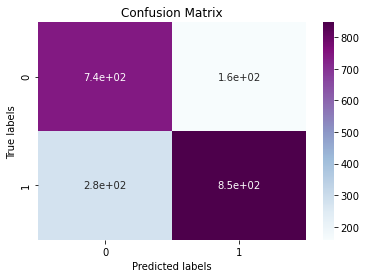

In [35]:
plot_conf(ypred,y_test)

In [37]:
from sklearn.metrics import accuracy_score,precision_score, recall_score
precision_score(ypred,y_test)

0.841948310139165

In [38]:
recall_score(ypred,y_test)

0.7528888888888889

In [39]:
accuracy_score(ypred,y_test)

0.784516765285996